In [ ]:
from google.colab import drive, userdata
drive.mount("/content/drive")
HF_TOKEN = userdata.get("HF_CREDENTIALS")

Mounted at /content/drive


In [ ]:
!pip install datasets --quiet
!pip install emoji --quiet
!pip install -Uq 'lightgbm>=4.0.0'

from datasets import load_dataset, load_from_disk, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import unicodedata
import re
import emoji
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import lightgbm as lgb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
stop = stopwords.words("english")
#lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    # Preprocess text for model encoding
    # Convert emojis to text
    text = emoji.demojize(text, delimiters=(" ", " "))
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    # Remove user mentions (@username)
    text = re.sub(r"@\w+", "", text)
    # Remove excessive special characters
    text = re.sub(r"[^\w\s,.!?;:()]", "", text)
    # Normalize spacing
    text = text.strip()
    return text

def preprocess_text_tfidf(df):
    # Preprocess text for tfidf visualizations
    text = df["text"]
    # Models only taking in 512 input tokens, ~400 words or 2.5k characters
    if len(text) > 3000:
      text = text[:3000]
    # Convert emojis to text
    text = emoji.demojize(text, delimiters=(" ", " "))
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    # Remove user mentions (@username)
    text = re.sub(r"@\w+", "", text)
    text = text.lower()
    # Remove stop words
    text = " ".join([word for word in text.split() if word not in stop])
    #Lemmatize and stem words
    #text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = " ".join([stemmer.stem(word) for word in text.split()])
    # Remove nonalphanumeric or spaces
    text = re.sub(r"[^\w\s]", "", text)
    #remove instances where there is only 1 character
    text = " ".join([word for word in text.split() if len(word) > 1 and not word.isnumeric()])
    # Normalize spacing
    text = re.sub('\s+', ' ', text)
    text = text.strip()

    return {'cleaned_text': text}

def tokenize_batch(examples):
  return tokenizer(examples['text'], max_length = 512, return_tensors = "pt", padding = True, truncation = True)

def encode_labels(examples):
  return {"labels": label2id[examples["labels"]]}


# Calculate TFIDF
def get_tfidf_unique_words(df, n_top_words = 30):
  df_processed = df.map(preprocess_text_tfidf)
  df_processed = pd.DataFrame({'text': df_processed['cleaned_text'], 'label': df["labels"]})
  # Filter to words that appear in 0.1% of corpus and take 1-3 ngrams
  vectorizer = TfidfVectorizer(min_df = 0.001, stop_words="english", ngram_range = (1,3))
  tfidf_matrix = vectorizer.fit_transform(df_processed["text"].astype(str))  # Fit TF-IDF to all text

  feature_names = vectorizer.get_feature_names_out()
  tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
  tfidf_df["label"] = df["labels"]
  # Get average tfidf per class
  class_tfidf = tfidf_df.groupby("label").mean()

  top_unique_words = {}
  for label in class_tfidf.index:
      class_scores = class_tfidf.loc[label]
      # Compute uniqueness: High in one class, low in others
      uniqueness_score = class_scores / (class_tfidf.sum(axis=0) + 1e-6)  # Normalize to prevent zero division
      # Get top n unique words for this class
      top_words = uniqueness_score.nlargest(n_top_words)
      top_unique_words[label] = top_words.to_dict()

  return top_unique_words

def compute_metrics(eval_pred):
    """Compute Accuracy, Precision, Recall, and F1-score."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    accuracy = accuracy_score(labels, predictions)
    # Compute Loss Manually
    logits_tensor = torch.tensor(logits)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    loss = F.cross_entropy(logits_tensor, labels_tensor).item()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "loss": loss
    }

def evaluate_test(model, tokenized_data):
  training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=32,
    do_train=False,  # Set to False to evaluate
    do_eval=True,
    fp16=True,
    report_to="none",
  )

  trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_data,
    compute_metrics=compute_metrics,
  )
  results = trainer.evaluate()
  return results

def get_probas(model, tokenized_data):
  training_args = TrainingArguments(
      output_dir="./results",
      per_device_eval_batch_size=32,
      do_train=False,  # Set to False to evaluate
      do_eval=True,
      fp16=True,
      report_to="none",
  )

  # Initialize Trainer
  trainer_mental_bert = Trainer(
      model=model,
      args=training_args
  )
  preds = trainer_mental_bert.predict(tokenized_data).predictions
  probas = torch.nn.functional.softmax(torch.tensor(preds), dim = -1)
  probas = pd.DataFrame(probas)
  probas.columns = ["teenager_proba", "depression_proba", "suicide_proba"]
  probas["index"] = tokenized_data["index"]
  probas["class"] = tokenized_data["labels"]
  return probas


In [ ]:
# Load in pre-trained models
tokenizer_mental_bert = AutoTokenizer.from_pretrained("jordanfan/mental-BERT_suicide_base")
model_mental_bert = AutoModelForSequenceClassification.from_pretrained("jordanfan/mental-BERT_suicide_base", token = HF_TOKEN, num_labels = 3, ignore_mismatched_sizes=True)
tokenizer_mental_roberta = AutoTokenizer.from_pretrained("jordanfan/mental-roberta_suicide_base")
model_mental_roberta = AutoModelForSequenceClassification.from_pretrained("jordanfan/mental-roberta_suicide_base", token = HF_TOKEN, num_labels = 3, ignore_mismatched_sizes = True)
# Deberta not initializing properly
tokenizer_deberta = AutoTokenizer.from_pretrained("jordanfan/deBERTa_suicide_base")
model_deberta = AutoModelForSequenceClassification.from_pretrained("jordanfan/deBERTA_suicide_base", token = HF_TOKEN, num_labels = 3, ignore_mismatched_sizes = True)
tokenizer_modernbert = AutoTokenizer.from_pretrained("jordanfan/modernBERT_suicide_base")
model_modernbert = AutoModelForSequenceClassification.from_pretrained("jordanfan/modernBERT_suicide_base", token = HF_TOKEN, num_labels = 3, ignore_mismatched_sizes = True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at djangodevloper/bert-base-sa-mental-uncased and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/4.15M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/773 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/598M [00:00<?, ?B/s]

In [ ]:
# Preprocessing for suicide depression data
df = load_dataset("jordanfan/suicide_depression")
df = df.rename_column("class", "labels")
train_df = df["train"].train_test_split(test_size = 0.2, seed = 42)
df["train"] = train_df["train"]
df["validation"] = train_df["test"]
df = df.filter(lambda x: x["text"] is not None and x["labels"] is not None and len(x["text"]) > 10)
id2label = {0: "teenagers", 1: "depression", 2: "SuicideWatch"}
label2id = {value: key for key, value in id2label.items()}
df = df.map(encode_labels)

train_df = df["train"]
train_df = train_df.add_column("index", list(range(len(train_df))))
val_df = df["validation"]
val_df = val_df.add_column("index", list(range(len(val_df))))
test_df = df["test"]
test_df = test_df.add_column("index", list(range(len(test_df))))

README.md:   0%|          | 0.00/417 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/155M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/38.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/278499 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/69625 [00:00<?, ? examples/s]

Filter:   0%|          | 0/222799 [00:00<?, ? examples/s]

Filter:   0%|          | 0/69625 [00:00<?, ? examples/s]

Filter:   0%|          | 0/55700 [00:00<?, ? examples/s]

Map:   0%|          | 0/222762 [00:00<?, ? examples/s]

Map:   0%|          | 0/69613 [00:00<?, ? examples/s]

Map:   0%|          | 0/55687 [00:00<?, ? examples/s]

# Evaluate on test set

In [ ]:
# Tokenize test set for each model
test_df = test_df.map(lambda x: {"text": preprocess_text(x["text"])})
tokenizer = tokenizer_mental_bert
tokenized_mental_bert = test_df.map(tokenize_batch, batched = True)
tokenizer = tokenizer_mental_roberta
tokenized_mental_roberta = test_df.map(tokenize_batch, batched = True)
tokenizer = tokenizer_modernbert
tokenized_modernbert = test_df.map(tokenize_batch, batched = True)

Map:   0%|          | 0/69613 [00:00<?, ? examples/s]

Map:   0%|          | 0/69613 [00:00<?, ? examples/s]

Map:   0%|          | 0/69613 [00:00<?, ? examples/s]

Map:   0%|          | 0/69613 [00:00<?, ? examples/s]

In [ ]:
results_mental_bert = evaluate_test(model_mental_bert, tokenized_mental_bert)
results_mental_roberta = evaluate_test(model_mental_roberta, tokenized_mental_roberta)
results_deberta = evaluate_test(model_deberta, tokenized_deberta)
results_modernbert = evaluate_test(model_modernbert, tokenized_modernbert)

In [ ]:
# Mental BERT results
pd.DataFrame({key: [value] for key,value in results_mental_bert.items()})[['eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1']]

,eval_accuracy,eval_precision,eval_recall,eval_f1
0,0.836266,0.837343,0.836266,0.836405


In [ ]:
# Mental RoBERTa results
pd.DataFrame({key: [value] for key,value in results_mental_roberta.items()})[['eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1']]

,eval_accuracy,eval_precision,eval_recall,eval_f1
0,0.854093,0.855107,0.854093,0.854456


In [ ]:
# DeBERTa results
pd.DataFrame({key: [value] for key,value in results_deberta.items()})[['eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1']]

,eval_accuracy,eval_precision,eval_recall,eval_f1
0,0.29789,0.284666,0.29789,0.163279


Fine-Tuned DeBERTa model does not appear to load in correctly, maybe the weights have reset

In [ ]:
# ModernBERT results
pd.DataFrame({key: [value] for key,value in results_modernbert.items()})[['eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1']]

,eval_accuracy,eval_precision,eval_recall,eval_f1
0,0.884691,0.888147,0.884691,0.884007


# Get Probas for Training / Validation / Test Set

In [ ]:
# Tokenize training set for each model
train_df = train_df.map(lambda x: {"text": preprocess_text(x["text"])})
tokenizer = tokenizer_mental_bert
tokenized_mental_bert_train = train_df.map(tokenize_batch, batched = True)
tokenizer = tokenizer_mental_roberta
tokenized_mental_roberta_train = train_df.map(tokenize_batch, batched = True)
tokenizer = tokenizer_modernbert
tokenized_modernbert_train = train_df.map(tokenize_batch, batched = True)

Map:   0%|          | 0/222762 [00:00<?, ? examples/s]

Map:   0%|          | 0/222762 [00:00<?, ? examples/s]

Map:   0%|          | 0/222762 [00:00<?, ? examples/s]

Map:   0%|          | 0/222762 [00:00<?, ? examples/s]

In [ ]:
# Tokenize validation set for each model
val_df = val_df.map(lambda x: {"text": preprocess_text(x["text"])})
tokenizer = tokenizer_mental_bert
tokenized_mental_bert_val = val_df.map(tokenize_batch, batched = True)
tokenizer = tokenizer_mental_roberta
tokenized_mental_roberta_val = val_df.map(tokenize_batch, batched = True)
tokenizer = tokenizer_modernbert
tokenized_modernbert_val = val_df.map(tokenize_batch, batched = True)

Map:   0%|          | 0/55687 [00:00<?, ? examples/s]

Map:   0%|          | 0/55687 [00:00<?, ? examples/s]

Map:   0%|          | 0/55687 [00:00<?, ? examples/s]

Map:   0%|          | 0/55687 [00:00<?, ? examples/s]

In [ ]:
# Get predicted probabilities for training set
probas_mental_bert = get_probas(model_mental_bert, tokenized_mental_bert_train)
probas_mental_roberta = get_probas(model_mental_roberta, tokenized_mental_roberta_train)
probas_modernbert = get_probas(model_modernbert, tokenized_modernbert_train)

probas_train = probas_mental_bert.merge(probas_mental_roberta.drop("class", axis = 1), on = "index", suffixes = ("", "_roberta"))\
                          .merge(probas_modernbert.drop("class", axis = 1), on = "index", suffixes = ("_bert", "_modernbert"))

with open("/content/drive/MyDrive/Colab Notebooks/probas_train.pkl", "wb") as f:
  pickle.dump(probas_train, f)

In [ ]:
# Get predicted probabilities for validation set
probas_mental_bert = get_probas(model_mental_bert, tokenized_mental_bert_val)
probas_mental_roberta = get_probas(model_mental_roberta, tokenized_mental_roberta_val)
probas_modernbert = get_probas(model_modernbert, tokenized_modernbert_val)

probas_val = probas_mental_bert.merge(probas_mental_roberta.drop("class", axis = 1), on = "index", suffixes = ("", "_roberta"))\
                          .merge(probas_modernbert.drop("class", axis = 1), on = "index", suffixes = ("_bert", "_modernbert"))

with open("/content/drive/MyDrive/Colab Notebooks/probas_val.pkl", "wb") as f:
  pickle.dump(probas_val, f)

In [ ]:
# Get predicted probabilities for test set
probas_mental_bert = get_probas(model_mental_bert, tokenized_mental_bert)
probas_mental_roberta = get_probas(model_mental_roberta, tokenized_mental_roberta)
probas_modernbert = get_probas(model_modernbert, tokenized_modernbert)

probas_test = probas_mental_bert.merge(probas_mental_roberta.drop("class", axis = 1), on = "index", suffixes = ("", "_roberta"))\
                          .merge(probas_modernbert.drop("class", axis = 1), on = "index", suffixes = ("_bert", "_modernbert"))

with open("/content/drive/MyDrive/Colab Notebooks/probas_test.pkl", "wb") as f:
  pickle.dump(probas_test, f)

# Create Blended Model (Boosted Trees)

In [ ]:
!pip install -Uq 'lightgbm>=4.0.0'
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
import numpy as np
import pandas as pd
import lightgbm as lgb
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/probas_val.pkl", "rb") as f:
  probas_val = pickle.load(f)
probas_val.drop(columns = ["index"], inplace = True)
y_val = np.array(probas_val["class"])
val_proba = np.array(probas_val.drop(columns = ["class"]))
# Split validation set to use to fine-tune boosted tree model for blending
val_proba_train, val_proba_validation, y_val_train, y_val_validation = train_test_split(
    val_proba, y_val, test_size=0.1, random_state=42)

In [ ]:
# Best parameters from hyperparameter tuning from ensembling_boosted_trees.ipynb
params = {
 'learning_rate': 0.001,
 'min_child_samples': 10,
 'n_estimators': 2000,
 'num_leaves': 5,
 'random_state': 42,
 'reg_alpha': 0.1}

lgb_model = lgb.LGBMClassifier(**params)
lgb_model.fit(val_proba_train, y_val_train)
lgb_model.booster_.save_model("/content/drive/MyDrive/Colab Notebooks/W210/lgb_model.txt")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 50118, number of used features: 9
[LightGBM] [Info] Start training from score -1.099630
[LightGBM] [Info] Start training from score -1.098732
[LightGBM] [Info] Start training from score -1.097476


# Evaluate Blended Models on Test Set

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/probas_test.pkl", "rb") as f:
  probas_test = pickle.load(f)
probas_test.drop(columns = ["index"], inplace = True)
y_test = np.array(probas_test["class"])
test_proba = np.array(probas_test.drop(columns = ["class"]))

In [ ]:
# Create ensembling through voting
# If any model predicts suicide, predict suicide. Otherwise, take the most common predictions from the 3 models

def most_common(lst):
    return max(set(lst), key=lst.count)

mental_bert_preds = np.argmax(np.array(probas_test[["teenager_proba_bert", "depression_proba_bert", "suicide_proba_bert"]]), axis = 1)
mental_roberta_preds = np.argmax(np.array(probas_test[["teenager_proba_roberta", "depression_proba_roberta", "suicide_proba_roberta"]]), axis = 1)
modernbert_preds = np.argmax(np.array(probas_test[["teenager_proba_modernbert", "depression_proba_modernbert", "suicide_proba_modernbert"]]), axis = 1)

voting_preds = np.array(pd.DataFrame({"mental_bert_preds": mental_bert_preds,
                                      "mental_roberta_preds": mental_roberta_preds,
                                      "modernbert_preds": modernbert_preds})\
                        .apply(lambda x: 2 if any([x["mental_bert_preds"] == 2,
                                                   x["mental_roberta_preds"] == 2,
                                                   x["modernbert_preds"] == 2]) else
                               most_common([x["mental_bert_preds"],
                                            x["mental_roberta_preds"],
                                            x["modernbert_preds"]]), axis = 1))

precision, recall, f1, _ = precision_recall_fscore_support(y_test, voting_preds, average="weighted")
accuracy = accuracy_score(y_test, voting_preds)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8591211411661615
Precision: 0.8730356887272818
Recall: 0.8591211411661615
F1 Score: 0.8586739023525789


# Classification Reports

In [ ]:
# Mental BERT
print(classification_report(y_test, mental_bert_preds, digits = 3))

              precision    recall  f1-score   support

           0      0.947     0.934     0.941     23183
           1      0.792     0.755     0.773     23277
           2      0.773     0.820     0.796     23153

    accuracy                          0.836     69613
   macro avg      0.837     0.836     0.836     69613
weighted avg      0.837     0.836     0.836     69613



In [ ]:
# Mental RoBERTa
print(classification_report(y_test, mental_roberta_preds, digits = 3))

              precision    recall  f1-score   support

           0      0.979     0.965     0.972     23183
           1      0.802     0.783     0.792     23277
           2      0.785     0.815     0.800     23153

    accuracy                          0.854     69613
   macro avg      0.855     0.854     0.855     69613
weighted avg      0.855     0.854     0.854     69613



In [ ]:
# ModernBERT
print(classification_report(y_test, modernbert_preds, digits = 3))

              precision    recall  f1-score   support

           0      0.985     0.994     0.989     23183
           1      0.885     0.767     0.822     23277
           2      0.795     0.895     0.842     23153

    accuracy                          0.885     69613
   macro avg      0.888     0.885     0.884     69613
weighted avg      0.888     0.885     0.884     69613



In [ ]:
# Blended Boosted Trees
print(classification_report(y_test, blended_test_preds, digits = 3))


              precision    recall  f1-score   support

           0      0.985     0.994     0.989     23183
           1      0.862     0.803     0.831     23277
           2      0.817     0.866     0.841     23153

    accuracy                          0.887     69613
   macro avg      0.888     0.887     0.887     69613
weighted avg      0.888     0.887     0.887     69613



In [ ]:
# Ensembled Voting
print(classification_report(y_test, voting_preds, digits = 3))


              precision    recall  f1-score   support

           0      0.990     0.956     0.973     23183
           1      0.891     0.699     0.784     23277
           2      0.738     0.923     0.820     23153

    accuracy                          0.859     69613
   macro avg      0.873     0.859     0.859     69613
weighted avg      0.873     0.859     0.859     69613



In [ ]:
misclassified_labels = y_test[y_test != blended_test_preds]
misclassified_preds = blended_test_preds[blended_test_preds != y_test]

misclassified = pd.DataFrame({"labels": misclassified_labels, "preds": misclassified_preds})
misclassified["label|prediction"] = misclassified["labels"].astype(str) + " | " + misclassified["preds"].astype(str)
misclassified["label|prediction"].value_counts()

,count
label|prediction,
1 | 2,4419
2 | 1,2925
1 | 0,178
2 | 0,176
0 | 2,73
0 | 1,69


# TF-IDF Across Classes

In [ ]:
import pickle
top_unique_words = get_tfidf_unique_words(train_df, n_top_words = 30)
with open("/content/drive/MyDrive/Colab Notebooks/top_unique_words_all.pkl", "wb") as f:
  pickle.dump(top_unique_words, f)

Map:   0%|          | 0/222762 [00:00<?, ? examples/s]

In [ ]:
dfs = [pd.DataFrame({"feature": list(top_unique_words[i].keys()), "tfidf": list(top_unique_words[i].values()), "label": i}) for i in top_unique_words.keys()]

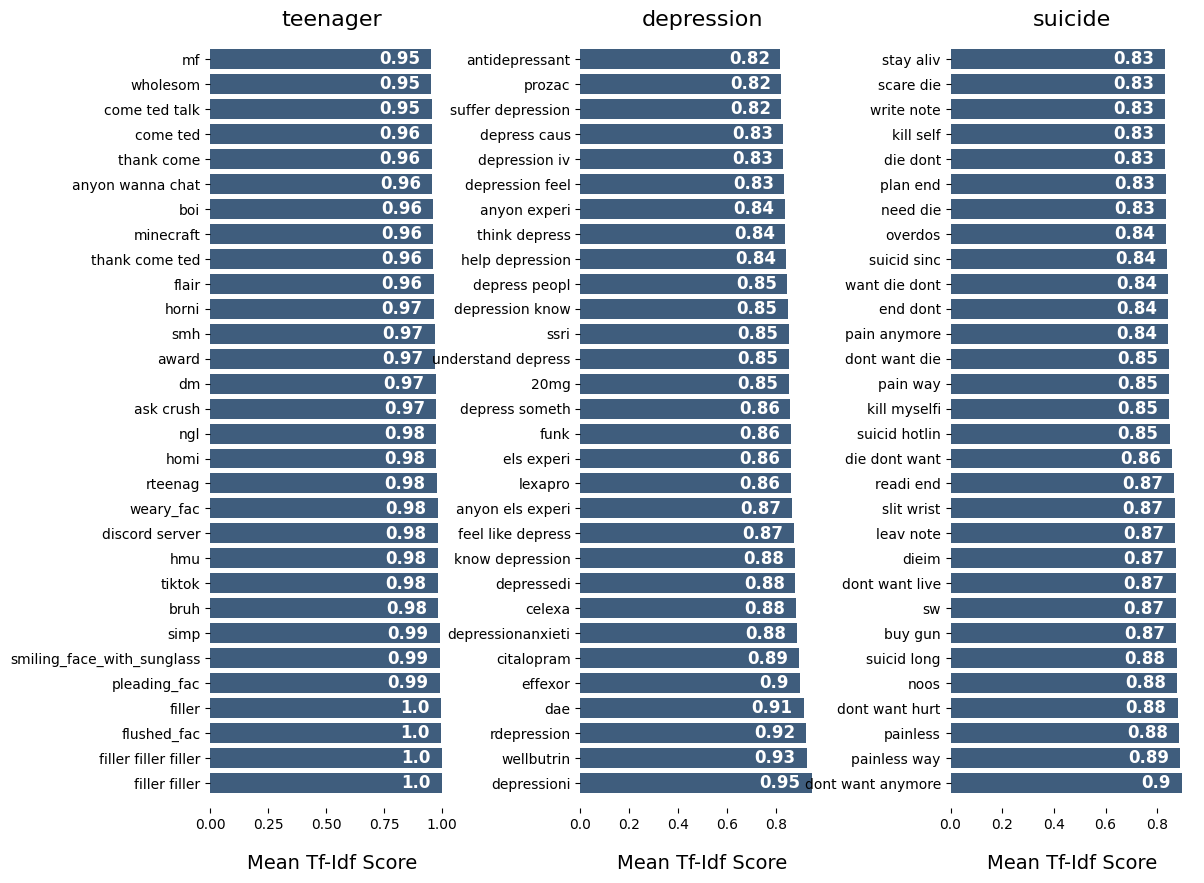

In [ ]:
fig = plt.figure(figsize=(12, 9), facecolor="w")
x = np.arange(len(dfs[0]))
label = ["teenager", "depression", "suicide"]
for i, df in enumerate(dfs):
    ax = fig.add_subplot(1, len(dfs), i+1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_frame_on(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
    ax.set_title(label[i], fontsize=16)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    bars = ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
    #ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
    ax.set_yticks(x)
    ax.set_ylim([-1, x[-1]+1])
    yticks = ax.set_yticklabels(df.feature)

    for bar in bars:
        width = bar.get_width()
        ax.text(width * 0.95,  # X position (near the end of the bar)
                bar.get_y() + bar.get_height() / 2,  # Y position (center of bar)
                f"{round(width, 2)}",  # Format text in scientific notation
                ha='right',  # Align text to the right
                va='center',  # Align text to the center
                fontsize=12,
                color="white" if width > 0.1 else "black",  # Contrast text with bar color
                fontweight='bold')

    plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
plt.show()

## TF-IDF Across Classes (Misclassified Examples)

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/probas_train.pkl", "rb") as f:
  probas_train = pickle.load(f)
y_train = np.array(probas_train["class"])
train_proba = np.array(probas_train.drop(columns = ["class", "index"]))

lgb_model = lgb.Booster(model_file="/content/drive/MyDrive/Colab Notebooks/W210/lgb_model.txt")
blended_train_preds = np.argmax(lgb_model.predict(train_proba), axis = 1)
probas_train["predictions"] = blended_train_preds
misclassified_indices = probas_train[probas_train["predictions"] != probas_train["class"]]["index"]

In [ ]:
misclassified_train = train_df.filter(lambda x: x["index"] in misclassified_indices)
top_misclassified_unique_words = get_tfidf_unique_words(misclassified_train, n_top_words = 30)


Map:   0%|          | 0/20548 [00:00<?, ? examples/s]

In [ ]:
dfs_misclassified = [pd.DataFrame({"feature": list(top_misclassified_unique_words[i].keys()),
                                   "tfidf": list(top_misclassified_unique_words[i].values()),
                                   "label": i}) for i in top_misclassified_unique_words.keys()]

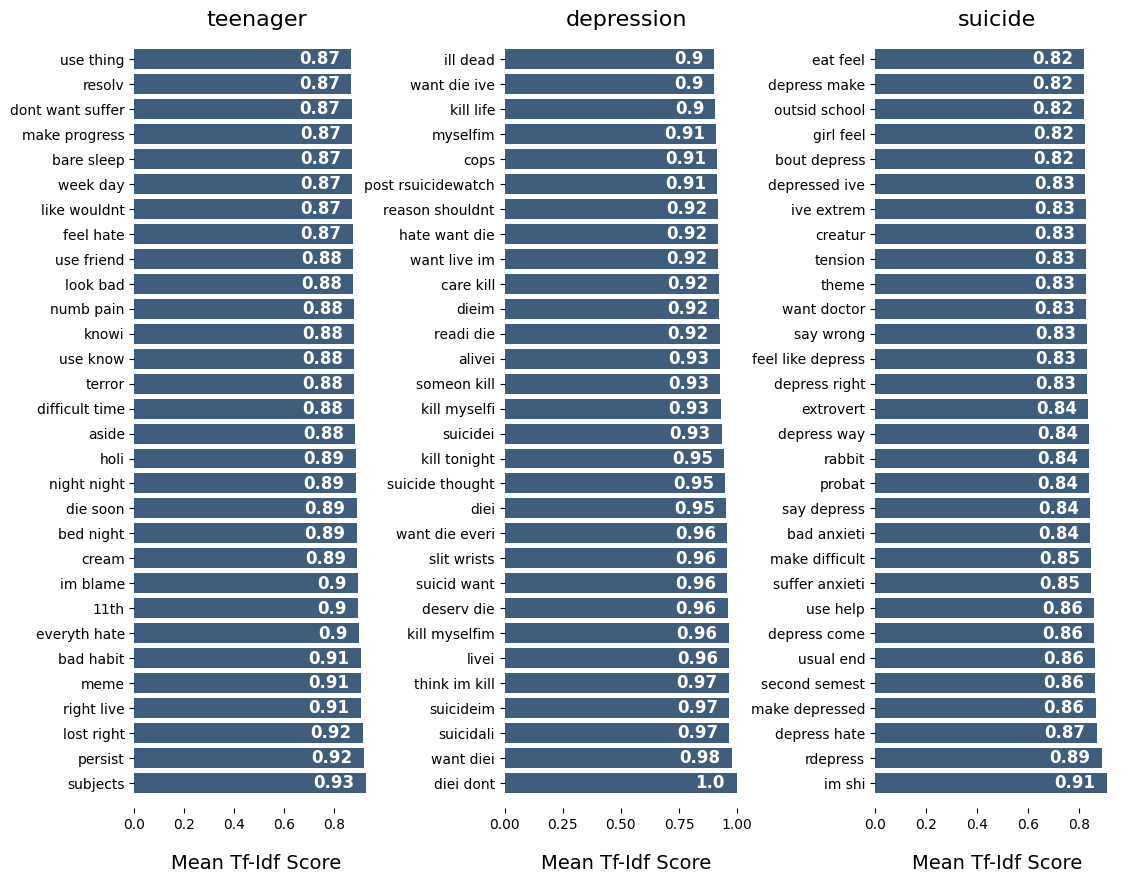

In [ ]:
fig = plt.figure(figsize=(12, 9), facecolor="w")
x = np.arange(len(dfs_misclassified[0]))
label = ["teenager", "depression", "suicide"]
for i, df in enumerate(dfs_misclassified):
    ax = fig.add_subplot(1, len(dfs_misclassified), i+1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_frame_on(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
    ax.set_title(label[i], fontsize=16)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    bars = ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
    #ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
    ax.set_yticks(x)
    ax.set_ylim([-1, x[-1]+1])
    yticks = ax.set_yticklabels(df.feature)

    for bar in bars:
        width = bar.get_width()
        ax.text(width * 0.95,  # X position (near the end of the bar)
                bar.get_y() + bar.get_height() / 2,  # Y position (center of bar)
                f"{round(width, 2)}",  # Format text in scientific notation
                ha='right',  # Align text to the right
                va='center',  # Align text to the center
                fontsize=12,
                color="white" if width > 0.1 else "black",  # Contrast text with bar color
                fontweight='bold')

    plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
plt.show()